In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', 500)

In [ ]:
#df2 = pd.read_csv('/content/drive/MyDrive/Machine Learning Deliverable/data/spotify2_transformed.csv')
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Deliverable/data/spotify2_21_5.csv')
df.shape

(38119, 14)

In [ ]:
df.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,vocal_density,vocal_expression
0,0.774,0.503,5,-8.994,0.0442,0.2640,0.075700,0.0746,0.2710,140.003,146187,Dark Trap,0.880100,0.011978
1,0.583,0.669,0,-7.136,0.1440,0.0524,0.000007,0.0889,0.7500,159.966,157500,Emo,0.855993,0.108000
2,0.628,0.873,11,-3.476,0.3230,0.1820,0.001130,0.5580,0.1630,160.023,183405,Dark Trap,0.675870,0.052649
3,0.448,0.784,9,-3.686,0.0627,0.1060,0.000108,0.6680,0.2360,136.245,186813,Pop,0.937192,0.014797
4,0.421,0.582,2,-8.257,0.0531,0.1980,0.377000,0.1490,0.0763,135.763,109394,Trap Metal,0.569900,0.004052


Let's plot the distribution of the classes in our dataset.

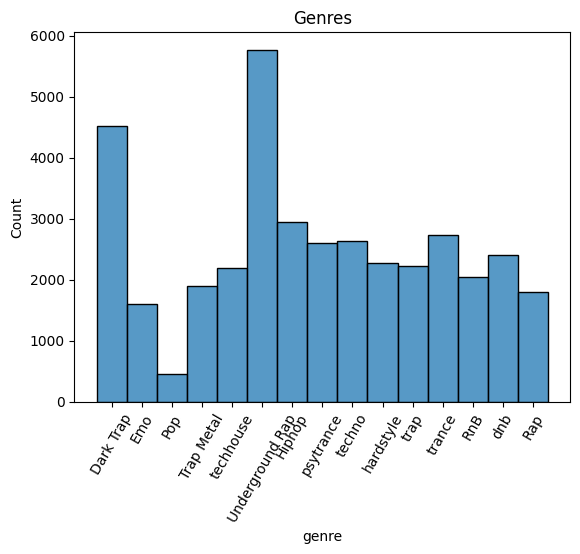

In [ ]:
def plot_genre(df):
  ax = sns.histplot(df["genre"])
  ax = plt.xticks(rotation=60)
  ax = plt.title("Genres")
plot_genre(df)

There are some genres more represented (Underground Rap, Dark Trap) or less represented (Pop). Thus we have an imbalance dataset. We tried some methods in order to deal with this imbalance. Initially, before any technique is applied we create a baseline with Gaussian Naive Bayes, in order to compare metrics like F1 in every tried technique afterwards. In this baseline the F1 average in all labels in the validation set is 52.55%.

In [ ]:
np.random.seed(6046)

We initially split the data in train and test with a 67%-33% split. Then the train data is again splitted to train and validation, again by a 67%-33% split. So, we end up with 3 sets, train (44.88%), validation (22.10%) and testing (33%) sets in total of 37667 observations. In both splits we split with stratify by our target genre column. After the first split and before the second we also scale the data with the MinMaxScaler and then apply it to the test set.

In [ ]:
def split_data(df):
  X = df.loc[:, df.columns != 'genre']
  y = df['genre']

  scaler = MinMaxScaler()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=df.loc[:,'genre'])
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.33, stratify=y_train, random_state=42)
  return X_train, X_test_scaled, X_val, y_train, y_test, y_val

In [ ]:
labels = list(df['genre'].unique())
results_df = pd.DataFrame()
def compute_metrics(y_true, y_pred, labels, algorithm_name, results_df=None):
    accuracy = accuracy_score(y_true, y_pred)
    f1_scores = f1_score(y_true, y_pred, average=None, labels=labels)
    f1_score_avg = f1_score(y_true, y_pred, average='macro')

    # If results_df is not provided or empty, create a new DataFrame
    if results_df is None or results_df.empty:
        columns = ['Algorithm', 'Accuracy', 'F1_Avg'] + [f'F1_{label}' for label in labels]
        results_df = pd.DataFrame(columns=columns)

    # Append results to the DataFrame with algorithm name as index
    results_df.loc[len(results_df)] = [algorithm_name, accuracy, f1_score_avg] + list(f1_scores)

    return results_df

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(df)

In [ ]:
def run_gaussianNB(X_train,y_train, X_val, y_val, labels, results_df, name):
  gauss_nb = GaussianNB()
  gauss_nb.fit(X_train,y_train)

  y_pred = gauss_nb.predict(X_val)

  return compute_metrics(y_val, y_pred, labels, name, results_df)

In [ ]:
results_df = run_gaussianNB(X_train,y_train, X_val, y_val, labels, results_df, 'GaussianNB-default')

In [ ]:
results_df

,Algorithm,Accuracy,F1_Avg,F1_Dark Trap,F1_Emo,F1_Pop,F1_Trap Metal,F1_techhouse,F1_Underground Rap,F1_Hiphop,F1_psytrance,F1_techno,F1_hardstyle,F1_trap,F1_trance,F1_RnB,F1_dnb,F1_Rap
0,GaussianNB-default,0.539274,0.525566,0.325747,0.398034,0.204082,0.233333,0.782902,0.44358,0.401051,0.774734,0.762969,0.734463,0.618532,0.647955,0.284889,0.931268,0.339956


First thing tried was to remove all observations that had Pop genre as a label, since it had around 400 observations and all the other labels had more than 1500. This of course helped the model, since we are measuring in one less class, in which the performance was pretty bad and below the average (20.40%). Now the F1_avg is 54.91%.

In [ ]:
df.drop(df.loc[df['genre']=="Pop"].index, inplace=True)
df.reset_index(drop = True, inplace=True)

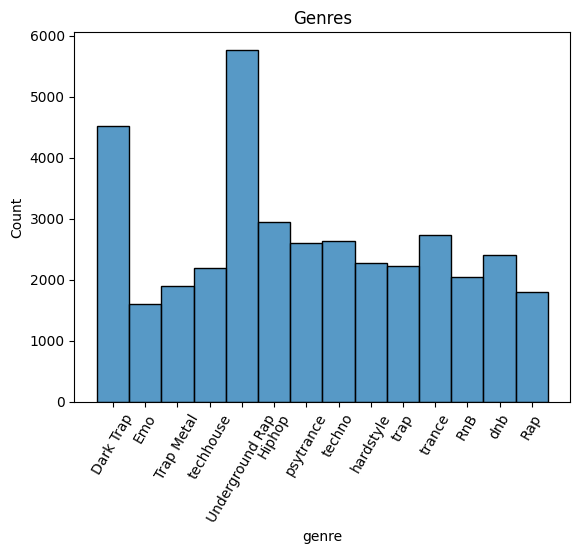

In [ ]:
plot_genre(df)

In [ ]:
df.to_csv('/content/drive/MyDrive/Machine Learning Deliverable/data/spotify_ml_21_5.csv', index=False)

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(df)
results_df = run_gaussianNB(X_train,y_train, X_val, y_val, labels, results_df, 'GaussianNB-default-drop-Pop')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


We store these splits of train, val, testing so we use exactly the same splits in our ML models and so they are reproducible.

In [ ]:
#to save it
with open("/content/drive/MyDrive/Machine Learning Deliverable/data/split/train.pkl", "wb") as f:
    pkl.dump([X_train, y_train], f)

with open("/content/drive/MyDrive/Machine Learning Deliverable/data/split/val.pkl", "wb") as f:
    pkl.dump([X_val, y_val], f)

with open("/content/drive/MyDrive/Machine Learning Deliverable/data/split/test.pkl", "wb") as f:
    pkl.dump([X_test, y_test], f)

In [ ]:
results_df

,Algorithm,Accuracy,F1_Avg,F1_Dark Trap,F1_Emo,F1_Pop,F1_Trap Metal,F1_techhouse,F1_Underground Rap,F1_Hiphop,F1_psytrance,F1_techno,F1_hardstyle,F1_trap,F1_trance,F1_RnB,F1_dnb,F1_Rap
0,GaussianNB-default,0.539274,0.525566,0.325747,0.398034,0.204082,0.233333,0.782902,0.44358,0.401051,0.774734,0.762969,0.734463,0.618532,0.647955,0.284889,0.931268,0.339956
1,GaussianNB-default-drop-Pop,0.548151,0.549127,0.335694,0.394756,0.000000,0.232479,0.779847,0.46356,0.399027,0.786834,0.736089,0.732580,0.608076,0.659341,0.311759,0.926214,0.321519


In [ ]:
df['genre'].value_counts()

genre
Underground Rap    5771
Dark Trap          4518
Hiphop             2954
trance             2734
techno             2632
psytrance          2610
dnb                2407
hardstyle          2277
trap               2226
techhouse          2192
RnB                2039
Trap Metal         1897
Rap                1809
Emo                1601
Name: count, dtype: int64

Oversampling

Then, we tried an oversampling technique, SMOTE (Synthetic Minority Oversampling Technique). It is an oversampling technique where the synthetic samples are generated for the minority class. The result of this was to have 2590 rows referring to each one of the labels. It is interesting that SMOTE decreased the performance dropping it to 53.65%. The performance in almost all classes was decreased, but in Underground Rap it was a significant drop.


Undersampling

Next, we tried undersampling this time, with NearMiss. It selects samples from the majority class that are closest to the minority class, reducing the overlap between the two classes. Using this made each class to have 719 observations with an F1_Avg of 50.88%. This is a significant drop from our baseline, but that makes sense since the total number of samples is majorly decreased.

In [ ]:
def sampling(name):
  unique_resampled, counts_resampled = np.unique(y_train, return_counts=True)
  print(f"Class distribution in the training set before {name}:", dict(zip(unique_resampled, counts_resampled)))
  if name == 'SMOTE':
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
  elif name == 'NearMiss':
    nr = NearMiss()
    X_train_resampled, y_train_resampled = nr.fit_resample(X_train, y_train)

  unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
  print(f"Class distribution in the training set before {name}:", dict(zip(unique_resampled, counts_resampled)))
  return X_train_resampled, y_train_resampled

In [ ]:
X_train_resampled, y_train_resampled = sampling('SMOTE')
results_df = run_gaussianNB(X_train_resampled, y_train_resampled, X_val, y_val, labels, results_df, 'GaussianNB-default-drop-Pop-SMOTE')

Class distribution in the training set before SMOTE: {'Dark Trap': 2028, 'Emo': 719, 'Hiphop': 1326, 'Rap': 812, 'RnB': 915, 'Trap Metal': 852, 'Underground Rap': 2590, 'dnb': 1081, 'hardstyle': 1022, 'psytrance': 1172, 'techhouse': 984, 'techno': 1181, 'trance': 1227, 'trap': 999}
Class distribution in the training set before SMOTE: {'Dark Trap': 2590, 'Emo': 2590, 'Hiphop': 2590, 'Rap': 2590, 'RnB': 2590, 'Trap Metal': 2590, 'Underground Rap': 2590, 'dnb': 2590, 'hardstyle': 2590, 'psytrance': 2590, 'techhouse': 2590, 'techno': 2590, 'trance': 2590, 'trap': 2590}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
X_train_resampled, y_train_resampled = sampling('NearMiss')
results_df = run_gaussianNB(X_train_resampled, y_train_resampled, X_val, y_val, labels, results_df, 'GaussianNB-default-drop-Pop-NearMiss')

Class distribution in the training set before NearMiss: {'Dark Trap': 2028, 'Emo': 719, 'Hiphop': 1326, 'Rap': 812, 'RnB': 915, 'Trap Metal': 852, 'Underground Rap': 2590, 'dnb': 1081, 'hardstyle': 1022, 'psytrance': 1172, 'techhouse': 984, 'techno': 1181, 'trance': 1227, 'trap': 999}
Class distribution in the training set before NearMiss: {'Dark Trap': 719, 'Emo': 719, 'Hiphop': 719, 'Rap': 719, 'RnB': 719, 'Trap Metal': 719, 'Underground Rap': 719, 'dnb': 719, 'hardstyle': 719, 'psytrance': 719, 'techhouse': 719, 'techno': 719, 'trance': 719, 'trap': 719}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
results_df

,Algorithm,Accuracy,F1_Avg,F1_Dark Trap,F1_Emo,F1_Pop,F1_Trap Metal,F1_techhouse,F1_Underground Rap,F1_Hiphop,F1_psytrance,F1_techno,F1_hardstyle,F1_trap,F1_trance,F1_RnB,F1_dnb,F1_Rap
0,GaussianNB-default,0.539274,0.525566,0.325747,0.398034,0.204082,0.233333,0.782902,0.443580,0.401051,0.774734,0.762969,0.734463,0.618532,0.647955,0.284889,0.931268,0.339956
1,GaussianNB-default-drop-Pop,0.548151,0.549127,0.335694,0.394756,0.000000,0.232479,0.779847,0.463560,0.399027,0.786834,0.736089,0.732580,0.608076,0.659341,0.311759,0.926214,0.321519
2,GaussianNB-default-drop-Pop-SMOTE,0.514049,0.536526,0.327660,0.360349,0.000000,0.335938,0.780488,0.246246,0.391236,0.799024,0.741393,0.737154,0.629454,0.656000,0.284014,0.911794,0.310618
3,GaussianNB-default-drop-Pop-NearMiss,0.491955,0.508812,0.178755,0.479751,0.000000,0.265169,0.779363,0.312613,0.328224,0.710562,0.680820,0.674443,0.588865,0.572808,0.355519,0.918616,0.277865


Split Underground Rap

Underground Rap is the class with almost 6000 observations. Besides Dark Trap, these are more than double the observations of every other class. Thus, we thought of splitting it into two classes. We did that by finding the mean of its Underground Rap song’s ‘duration_ms’ and split it into two classes, one with the upper duration half and one with the lower. The F1_Avg was 53.81%, which means it did not help, even though we have now one more class.


In [ ]:
df_under_trap = df[df['genre']=='Underground Rap']
df_under_trap['duration_ms'].mean()

176207.64442904177

In [ ]:
# Define the condition for subclassing
condition = (df['genre'] == 'Underground Rap') & (df['duration_ms'] <= 176207.64442904177)

# Assign subclass label based on the condition
df.loc[condition, 'genre'] = 'Underground Rap_shorter'

condition = (df['genre'] == 'Underground Rap')
df.loc[condition, 'genre'] = 'Underground Rap_bigger'

In [ ]:
df['genre'].value_counts()

genre
Dark Trap                  4518
Underground Rap_shorter    3234
Hiphop                     2954
trance                     2734
techno                     2632
psytrance                  2610
Underground Rap_bigger     2537
dnb                        2407
hardstyle                  2277
trap                       2226
techhouse                  2192
RnB                        2039
Trap Metal                 1897
Rap                        1809
Emo                        1601
Name: count, dtype: int64

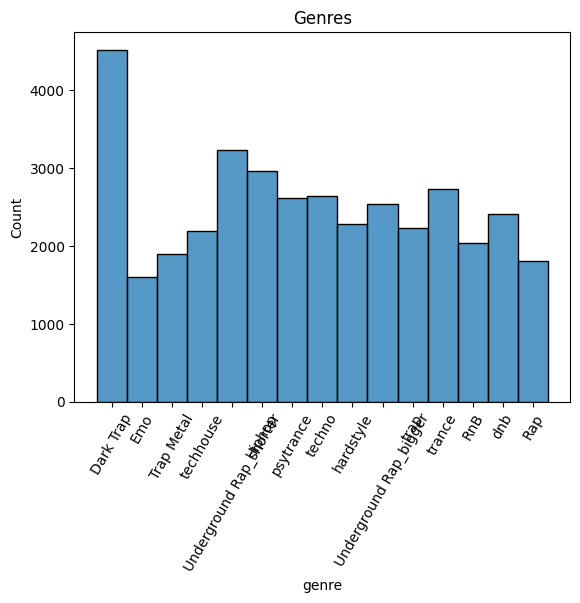

In [ ]:
plot_genre(df)

In [ ]:
labels = list(df['genre'].unique())
X_train, X_test, X_val, y_train, y_test, y_val = split_data(df)
results_df = run_gaussianNB(X_train,y_train, X_val, y_val, labels, results_df, 'GaussianNB-default-drop-Pop-split-undergroundTrap')
results_df

,Algorithm,Accuracy,F1_Avg,F1_Dark Trap,F1_Emo,F1_Pop,F1_Trap Metal,F1_techhouse,F1_Underground Rap,F1_Hiphop,F1_psytrance,F1_techno,F1_hardstyle,F1_trap,F1_trance,F1_RnB,F1_dnb,F1_Rap
0,GaussianNB-default,0.539274,0.525566,0.325747,0.398034,0.204082,0.233333,0.782902,0.443580,0.401051,0.774734,0.762969,0.734463,0.618532,0.647955,0.284889,0.931268,0.339956
1,GaussianNB-default-drop-Pop,0.548151,0.549127,0.335694,0.394756,0.000000,0.232479,0.779847,0.463560,0.399027,0.786834,0.736089,0.732580,0.608076,0.659341,0.311759,0.926214,0.321519
2,GaussianNB-default-drop-Pop-SMOTE,0.514049,0.536526,0.327660,0.360349,0.000000,0.335938,0.780488,0.246246,0.391236,0.799024,0.741393,0.737154,0.629454,0.656000,0.284014,0.911794,0.310618
3,GaussianNB-default-drop-Pop-NearMiss,0.491955,0.508812,0.178755,0.479751,0.000000,0.265169,0.779363,0.312613,0.328224,0.710562,0.680820,0.674443,0.588865,0.572808,0.355519,0.918616,0.277865
4,GaussianNB-default-drop-Pop-split-undergroundTrap,0.542627,0.538164,0.334764,0.355969,0.247492,0.791160,0.498382,0.352340,0.807988,0.762602,0.732883,0.341699,0.607059,0.686591,0.302491,0.926641,0.324393


In [ ]:
# df.to_csv('/content/drive/MyDrive/Machine Learning Deliverable/data/spotify_ml.csv', index=False)

In [ ]:
df['genre'].value_counts()

genre
Dark Trap                  4518
Underground Rap_shorter    3234
Hiphop                     2954
trance                     2734
techno                     2632
psytrance                  2610
Underground Rap_bigger     2537
dnb                        2407
hardstyle                  2277
trap                       2226
techhouse                  2192
RnB                        2039
Trap Metal                 1897
Rap                        1809
Emo                        1601
Name: count, dtype: int64